In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

In [2]:
# getting our dataset
df =              yf.download('AAPL')
df =              df.reset_index()
df['tmrw_close'] =      df['Close'].shift(-1) 

# getting the last 2 years of data. counting leap day because why not man
numberToGetLastTwoYears = len(df) - 731
df =              df.iloc[numberToGetLastTwoYears:].copy()

# rearranging the columns becuase I was kind of annoyed by the way yfinance gives it to us lol
cols =            df.columns.tolist()
cols =            cols[4:5] + cols[:4]    + cols[5:]
df =              df[cols]

# dropping the date because we don't need it and i forgot to do it earlier
df = df.drop(['Date'], axis=1)

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
df['tmrw_close'] =      df['tmrw_close'].fillna(method='ffill', limit=2)
data = df
data

[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,Adj Close,Volume,tmrw_close
9999,112.727501,112.599998,113.775002,110.000000,110.875603,212403600,109.375000
10000,109.375000,111.970001,112.482498,109.107498,107.578163,187902400,113.010002
10001,113.010002,110.497498,113.275002,110.297501,111.153458,165598000,115.010002
10002,115.010002,114.430000,116.042503,113.927498,113.120605,210082000,114.907501
10003,114.907501,114.830002,115.000000,113.044998,113.019775,165565200,114.607498
...,...,...,...,...,...,...,...
10725,189.589996,189.080002,190.070007,188.940002,189.589996,46347300,193.970001
10726,193.970001,191.630005,194.479996,191.259995,193.970001,85069600,192.460007
10727,192.460007,193.779999,193.880005,191.759995,192.460007,31458200,191.330002
10728,191.330002,191.570007,192.979996,190.619995,191.330002,46920300,191.809998


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (584, 7) trainY: (584,)
testX: (147, 7) testY: (147,)


In [27]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        # print(z) #Testing
        output = self.decode(z)
        return output, z, mu, logVar

In [28]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([17, 400, 400, 400, 10], 10)

tensor([[ 0.1011, -0.9495,  0.6489,  ...,  0.6593,  1.4561,  1.0571],
        [-0.3970,  0.8097,  1.4639,  ...,  1.2272, -0.1132,  1.0429],
        [-0.8831, -0.6360, -1.4208,  ..., -0.2180, -0.0911,  1.6106],
        ...,
        [-1.2124,  1.7888,  0.8769,  ..., -0.9573, -1.1216,  0.4060],
        [-0.8410, -0.0453,  1.5499,  ...,  0.1053,  0.0198,  0.7541],
        [-1.3279, -0.1077,  2.3227,  ..., -1.5818,  0.4518,  0.1582]],
       grad_fn=<AddBackward0>)
tensor([[ 0.3184, -0.2602,  0.3845,  ..., -0.3390, -0.5755,  0.0877],
        [ 0.7731,  0.1535, -0.0890,  ...,  0.7889, -0.6112, -0.6311],
        [-1.0784, -0.3569, -0.2695,  ...,  1.4429, -0.3178,  0.9682],
        ...,
        [-0.1922, -1.1156,  0.5600,  ..., -0.0358, -0.4626,  0.5522],
        [-0.0542,  0.0899, -0.4329,  ..., -0.1560,  1.1939,  0.7064],
        [-1.3135, -0.6428,  1.0638,  ...,  0.6298, -1.1668,  0.7689]],
       grad_fn=<AddBackward0>)
tensor([[ 0.0288, -0.2547, -0.8303,  ..., -0.3344,  1.3584,  0.3215],


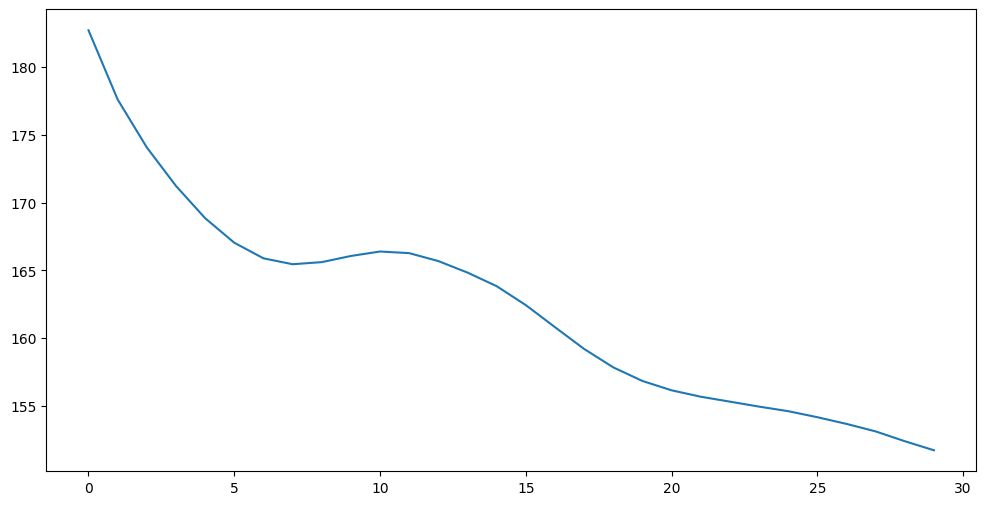

In [29]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 30 #ORIGINALLY 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        print(z)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [31]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [32]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [33]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [34]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([581, 3, 27]) train_y: torch.Size([581, 1]) train_y_gan: torch.Size([581, 4, 1])
test_x: torch.Size([144, 3, 27]) test_y: torch.Size([144, 1]) test_y_gan: torch.Size([144, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [12]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128 
learning_rate = 0.00016
num_epochs = 30 #ORIGINALLY 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(17).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/30] LossD: 6.929784417152405 LossG:3.4658015966415405
[2/30] LossD: 6.930559396743774 LossG:3.4659515619277954
[3/30] LossD: 6.934125900268555 LossG:3.469398558139801
[4/30] LossD: 6.930738687515259 LossG:3.4687016010284424
[5/30] LossD: 6.9313167333602905 LossG:3.465972065925598
[6/30] LossD: 6.931109070777893 LossG:3.465921103954315
[7/30] LossD: 6.9309775829315186 LossG:3.4661882519721985
[8/30] LossD: 6.930890679359436 LossG:3.466140031814575
[9/30] LossD: 6.930793046951294 LossG:3.4662256240844727
[10/30] LossD: 6.930773496627808 LossG:3.466197967529297
[11/30] LossD: 6.930863618850708 LossG:3.4661203622817993
[12/30] LossD: 6.931082606315613 LossG:3.465980291366577
[13/30] LossD: 6.931297302246094 LossG:3.4660885334014893
[14/30] LossD: 6.931442499160767 LossG:3.4663314819335938
[15/30] LossD: 6.931509613990784 LossG:3.4661675095558167
[16/30] LossD: 6.931463956832886 LossG:3.466531991958618
[17/30] LossD: 6.931451797485352 LossG:3.4660364985466003
[18/30] LossD: 6.93135309219

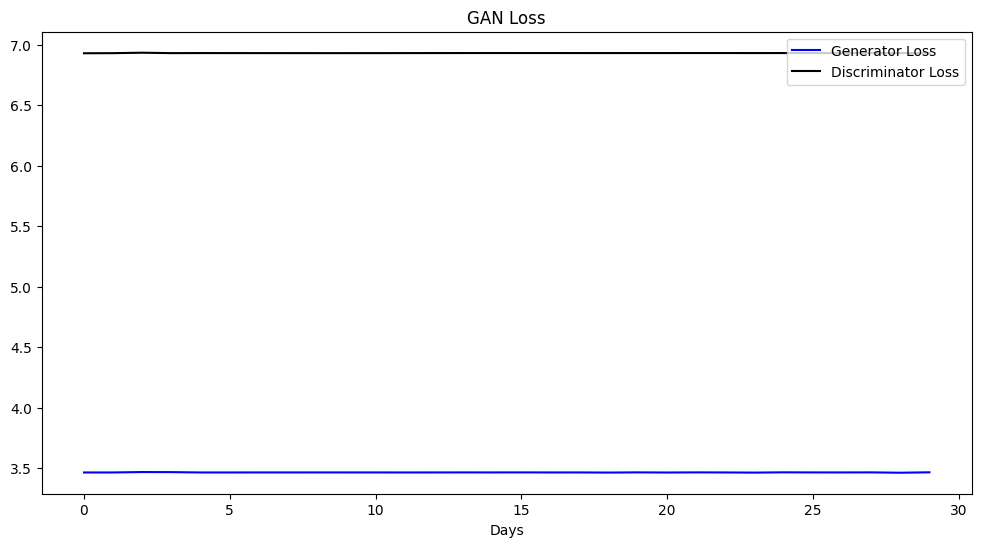

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [14]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())
print(y_train_pred)
y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

[[108.046036]
 [108.03384 ]
 [109.55345 ]
 [109.99485 ]
 [113.381546]
 [114.46443 ]
 [116.12417 ]
 [115.79242 ]
 [117.1671  ]
 [118.305275]
 [121.039894]
 [122.083206]
 [123.9332  ]
 [124.52606 ]
 [124.1123  ]
 [125.64403 ]
 [125.19841 ]
 [120.82865 ]
 [116.52233 ]
 [113.399216]
 [111.626526]
 [110.74425 ]
 [111.44803 ]
 [111.542114]
 [112.96953 ]
 [110.8498  ]
 [108.66417 ]
 [107.1605  ]
 [106.67939 ]
 [106.9504  ]
 [108.15973 ]
 [107.72945 ]
 [109.200356]
 [111.59788 ]
 [111.515495]
 [112.77819 ]
 [114.00422 ]
 [113.41328 ]
 [112.15745 ]
 [112.03736 ]
 [113.18211 ]
 [114.225525]
 [115.74721 ]
 [116.389114]
 [115.35787 ]
 [115.36672 ]
 [114.96568 ]
 [116.17183 ]
 [117.21574 ]
 [114.79158 ]
 [113.73433 ]
 [114.78568 ]
 [113.45124 ]
 [112.513855]
 [112.0192  ]
 [111.80726 ]
 [111.5056  ]
 [112.15676 ]
 [109.26206 ]
 [109.367386]
 [111.3414  ]
 [114.55795 ]
 [113.667984]
 [113.5329  ]
 [112.66019 ]
 [113.55183 ]
 [114.86539 ]
 [117.01063 ]
 [117.83383 ]
 [118.57795 ]
 [118.03924 ]
 [117.

Training dataset RMSE:5.923334298328189


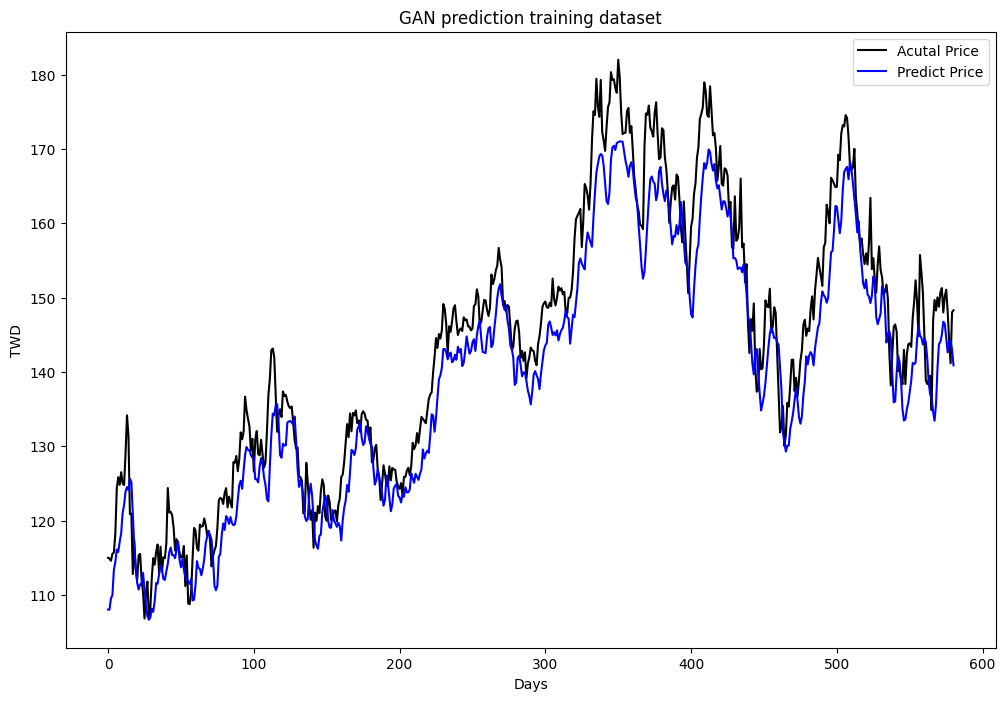

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:6.6929139644670315


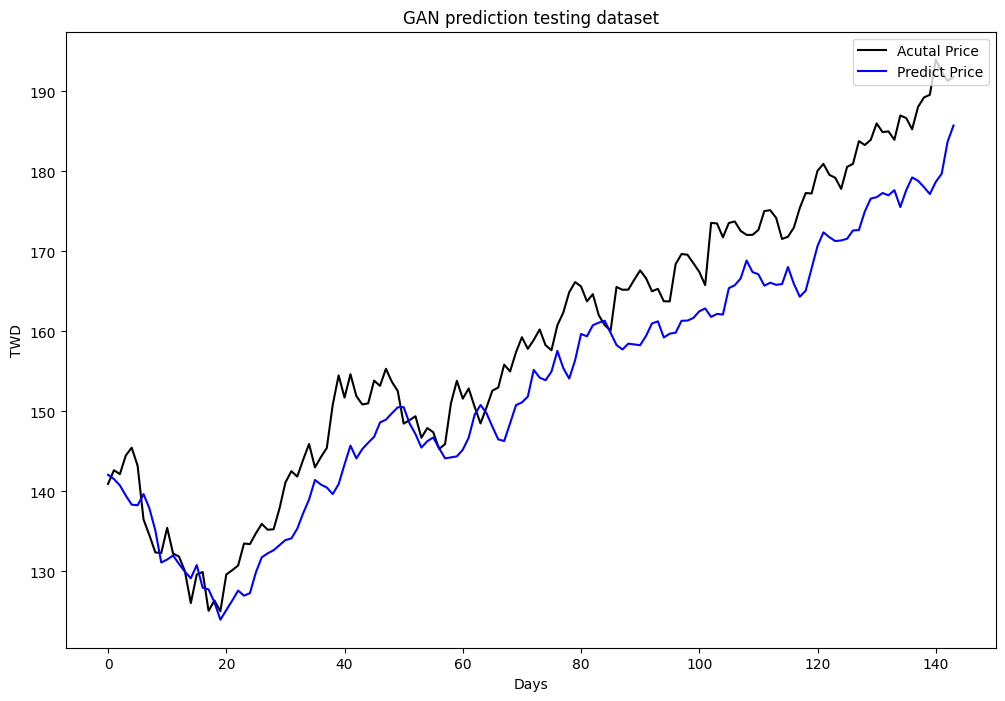

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')